_______
## RNN-based Point-Cloud Denoising in Snowy Weather Conditions"
### Authors: hphnngcquan, vuong-viet-hung

_______

In [203]:
# Common
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
# AHC
from sklearn.cluster import AgglomerativeClustering


Sprint01_AHC_Develop

In [204]:
%cd /media/anda/hdd/TheAnh/Pointcloud_Denoising_Snowy

/media/anda/hdd/TheAnh/Pointcloud_Denoising_Snowy


/home/anda/anaconda3/envs/lisa/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [267]:
from utils.clustering import ah_clustering_dense

In [290]:
def visualize(ax, labels, pointcloud, tag="gt"):
    '''
        Visualize Pointcloud For KITTI Velodyne Dataset
    '''

    if ((tag != "gt") & (labels != None)).any():
        label = pointcloud[:, 4]
        x, y, z = pointcloud[label == 2, :3].T
        nx, ny, nz = pointcloud[(label == 1), :3].T
    else:
        x, y, z = pointcloud[:, :3].T

    if ((tag != "gt") & (labels != None)).any():
        nx1 = [nx[x] for x in range(len(nx)) if labels[x] == 0]
        ny1 = [ny[x] for x in range(len(ny)) if labels[x] == 0]
        nz1 = [nz[x] for x in range(len(nz)) if labels[x] == 0]
        nx2 = [nx[x] for x in range(len(nx)) if labels[x] == 1]
        ny2 = [ny[x] for x in range(len(ny)) if labels[x] == 1]
        nz2 = [nz[x] for x in range(len(nz)) if labels[x] == 1]
        ax.scatter(nx1, ny1, nz1, s=3, c="blue", marker="o")
        ax.scatter(nx2, ny2, nz2, s=3, c="blue", marker="o")

    ax.scatter(x, y, z, s=2, c="white", marker="o")
    ax.view_init(elev=30, azim=210) 
    ax.set_axis_off()
    ax.set_facecolor('black')
    ax.set_xlim(5, 40)
    ax.set_title("PC Show", fontsize=20)
    ax.set_aspect("equal")  
    ax.set_zticklabels([])

In [278]:
# Temp test
dir = Path("data")
file_id = "000021"
noise_light = "light"
noise_heavy = "heavy"
noise_medium = "medium"
gt                  =   (dir / "gt" / file_id).with_suffix(".bin")
lidar_path_light    =   (dir / noise_light / file_id).with_suffix(".bin")
lidar_path_heavy    =   (dir / noise_heavy / file_id).with_suffix(".bin")
lidar_path_medium   =   (dir  / noise_medium / file_id).with_suffix(".bin")


[1 0 0 0 1 0]
[1.2805167, 1.5420312]
[2.139237, 1.6830133, 1.5589491, 1.556118]


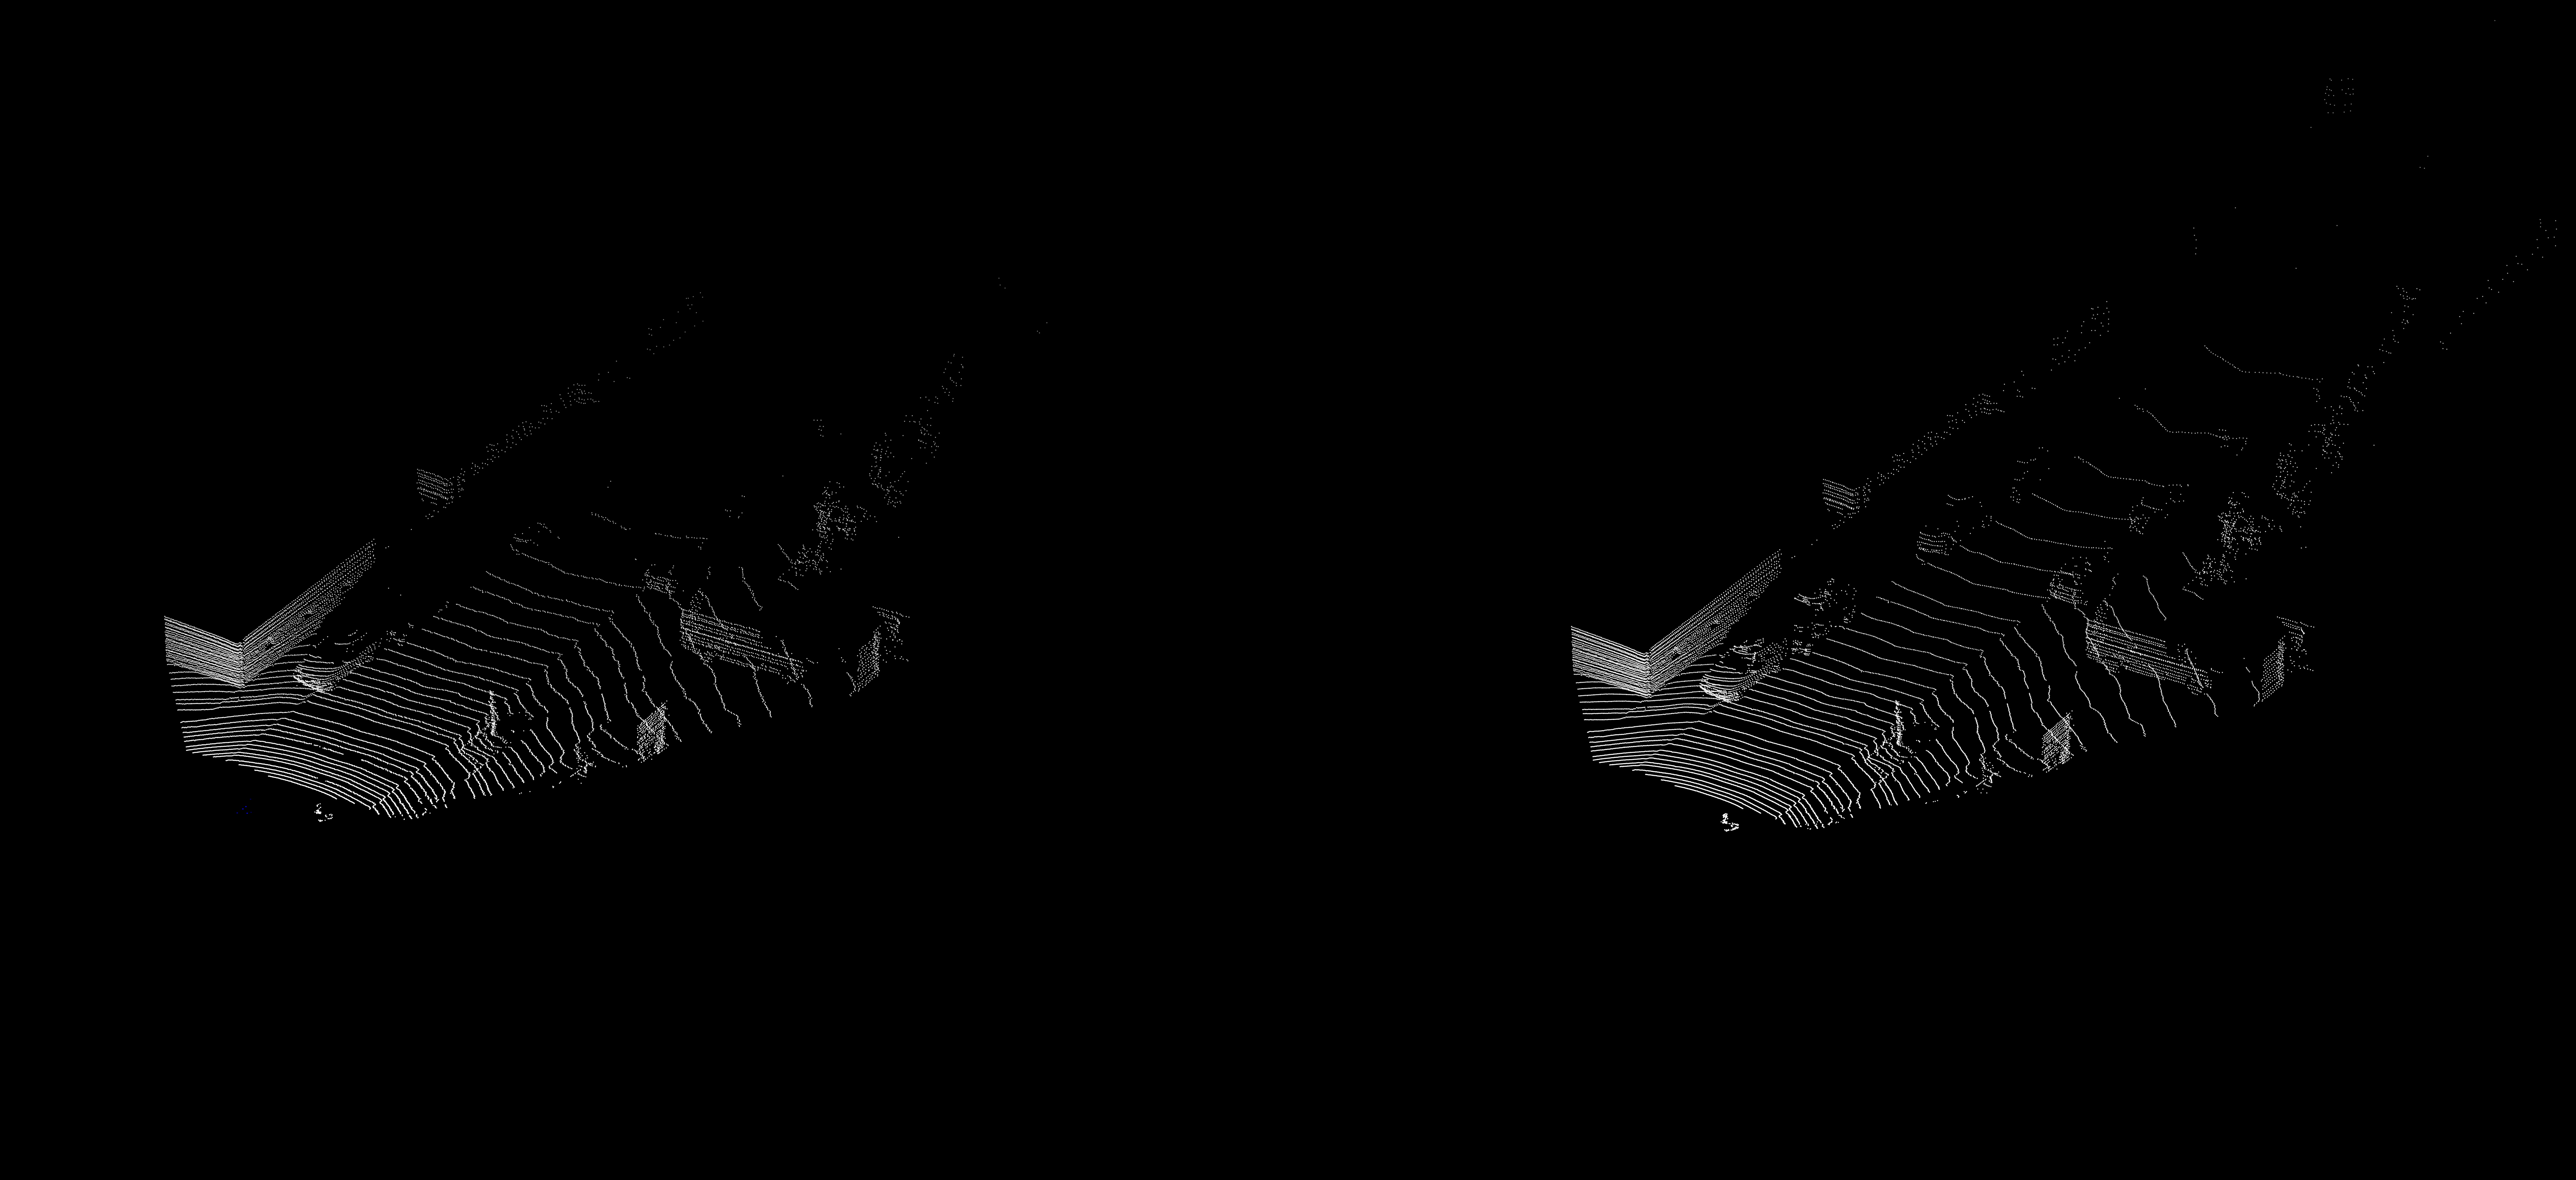

In [292]:
LIDAR_PATH = lidar_path_medium
labels, nx_group_1, nx_group_2 = ah_clustering_dense(LIDAR_PATH)
print(labels)
print(nx_group_1)
print(nx_group_2)

fig = plt.figure(figsize=(100, 100))
fig.patch.set_facecolor('black')
ax = fig.add_subplot(221, projection="3d")

pointcloud = np.fromfile(LIDAR_PATH, dtype=np.float32).reshape(-1, 5)
visualize(fig.add_subplot(221, projection="3d"), labels, pointcloud, tag="test")

pointcloud = np.fromfile(gt, dtype=np.float32).reshape(-1, 4)
visualize(fig.add_subplot(222, projection="3d"), labels, pointcloud, tag="gt")


In [20]:

TOP_Y_MIN = -30
TOP_Y_MAX = +30
TOP_X_MIN = 0
TOP_X_MAX = 100
TOP_Z_MIN = -3.5
TOP_Z_MAX = 0.6

TOP_X_DIVISION = 0.2
TOP_Y_DIVISION = 0.2
TOP_Z_DIVISION = 0.3



def lidar_to_top(lidar):

    idx = np.where(lidar[:, 0] > TOP_X_MIN)
    lidar = lidar[idx]
    idx = np.where(lidar[:, 0] < TOP_X_MAX)
    lidar = lidar[idx]

    idx = np.where(lidar[:, 1] > TOP_Y_MIN)
    lidar = lidar[idx]
    idx = np.where(lidar[:, 1] < TOP_Y_MAX)
    lidar = lidar[idx]

    idx = np.where(lidar[:, 2] > TOP_Z_MIN)
    lidar = lidar[idx]
    idx = np.where(lidar[:, 2] < TOP_Z_MAX)
    lidar = lidar[idx]

    pxs = lidar[:, 0]
    pys = lidar[:, 1]
    pzs = lidar[:, 2]
    prs = lidar[:, 3]
    qxs = ((pxs - TOP_X_MIN) // TOP_X_DIVISION).astype(np.int32)
    qys = ((pys - TOP_Y_MIN) // TOP_Y_DIVISION).astype(np.int32)
    # qzs=((pzs-TOP_Z_MIN)//TOP_Z_DIVISION).astype(np.int32)
    qzs = (pzs - TOP_Z_MIN) / TOP_Z_DIVISION
    quantized = np.dstack((qxs, qys, qzs, prs)).squeeze()

    X0, Xn = 0, int((TOP_X_MAX - TOP_X_MIN) // TOP_X_DIVISION) + 1
    Y0, Yn = 0, int((TOP_Y_MAX - TOP_Y_MIN) // TOP_Y_DIVISION) + 1
    Z0, Zn = 0, int((TOP_Z_MAX - TOP_Z_MIN) / TOP_Z_DIVISION)
    height = Xn - X0
    width = Yn - Y0
    channel = Zn - Z0 + 2
    # print('height,width,channel=%d,%d,%d'%(height,width,channel))
    top = np.zeros(shape=(height, width, channel), dtype=np.float32)

    # histogram = Bin(channel, 0, Zn, "z", Bin(height, 0, Yn, "y", Bin(width, 0, Xn, "x", Maximize("intensity"))))
    # histogram.fill.numpy({"x": qxs, "y": qys, "z": qzs, "intensity": prs})

    if 1:  # new method
        for x in range(Xn):
            ix = np.where(quantized[:, 0] == x)
            quantized_x = quantized[ix]
            if len(quantized_x) == 0:
                continue
            yy = -x

            for y in range(Yn):
                iy = np.where(quantized_x[:, 1] == y)
                quantized_xy = quantized_x[iy]
                count = len(quantized_xy)
                if count == 0:
                    continue
                xx = -y

                top[yy, xx, Zn + 1] = min(1, np.log(count + 1) / math.log(32))
                max_height_point = np.argmax(quantized_xy[:, 2])
                top[yy, xx, Zn] = quantized_xy[max_height_point, 3]

                for z in range(Zn):
                    iz = np.where(
                        (quantized_xy[:, 2] >= z) & (quantized_xy[:, 2] <= z + 1)
                    )
                    quantized_xyz = quantized_xy[iz]
                    if len(quantized_xyz) == 0:
                        continue
                    zz = z

                    # height per slice
                    max_height = max(0, np.max(quantized_xyz[:, 2]) - z)
                    top[yy, xx, zz] = max_height

    # if 0: #unprocess
    #     top_image = np.zeros((height,width,3),dtype=np.float32)
    #
    #     num = len(lidar)
    #     for n in range(num):
    #         x,y = qxs[n],qys[n]
    #         if x>=0 and x <width and y>0 and y<height:
    #             top_image[y,x,:] += 1
    #
    #     max_value=np.max(np.log(top_image+0.001))
    #     top_image = top_image/max_value *255
    #     top_image=top_image.astype(dtype=np.uint8)

    return top


def draw_top_image(lidar_top):
    top_image = np.sum(lidar_top, axis=2)
    top_image = top_image - np.min(top_image)
    divisor = np.max(top_image) - np.min(top_image)
    top_image = top_image / divisor * 255
    top_image = np.dstack((top_image, top_image, top_image)).astype(np.uint8)
    return top_image

In [23]:
pointcloud = np.fromfile(LIDAR_PATH, dtype=np.float32).reshape(-1, 5)
top = lidar_to_top(pointcloud)
img = draw_top_image(top)
cv2.imwrite("top_image.png", img)


True